# SEL635/SEL5724 - Visão Computacional Aplicada a Robótica

**Aluno:** Felipe Gomes de Melo

**NUSP:** Preencher com seu número USP

Versão do documento: 1.0

**Importante:** A lista deve ser feita de forma individual!

# Lista 3 - Gradiente, Bordas, Transformada de Hough, Detecção de Cantos

Os objetivos principais desta lista de exercício são:
*   Testar os algoritmos de detecção de borda;
*   Testar os algoritmos de detecção de cantos; 

**Não esqueça de conectar o Google Drive** no Colab usando o menu lateral, da mesma forma que foi feito na Lista 1.

In [39]:
# Carrega as bibliotecas para essa atividade
# from google.colab.patches import cv2_imshow # Necessário para mostrar imagens no Colab
import numpy as np
from matplotlib import pyplot as plt
import cv2
print(cv2.__version__) # Imprime a versão do OpenCV

4.4.0


## Parte A: Detecção de Bordas

Nesta parte do exercício os diferentes algoritmos de detecção de borda serão testados.

A função definida a seguir cria um padrão xadrez.

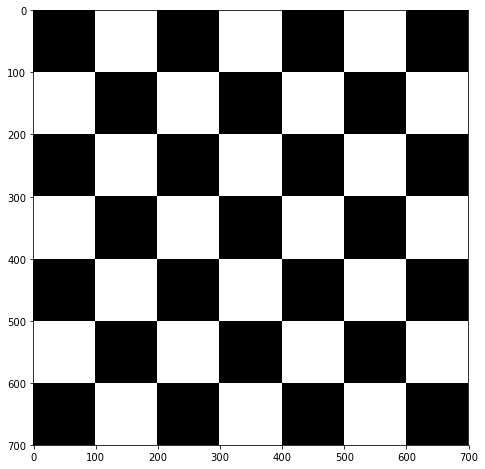

In [41]:
#img = cv2.imread('drive/My Drive/Colab Notebooks/test_images/buzz_gray.jpg',cv2.IMREAD_GRAYSCALE)
#print("\n Imagem original")
#cv2_imshow(img)

def padrao_xadrez():
    # Gera um padrão xadrez 700x700
    img = np.zeros((700,700,1))
    for i in range(7):
        for j in range(7):
            img[i*100:(i+1)*100,j*100:(j+1)*100,0] = ((i+j)%2)*255
    return img

img = padrao_xadrez()

plt.figure(figsize=(8,8))
plt.imshow(img.reshape(700, 700), cmap='gray')
plt.show()

Podemos corromper a imagem com ruído branco Gaussiano.

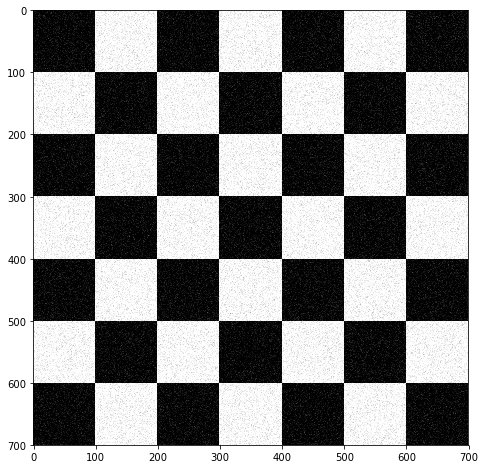

In [42]:
def adiciona_ruido_gaussiano(img,sigma):
    ruido = np.random.normal(0,sigma,img.shape)  # ruido é uma matriz da dimensão da imagem mas do tipo float64
    img_ruido = img+ruido # o resultado dessa soma será uma matriz do tipo float64
    img_ruido = np.clip(img_ruido, 0, 255) # Satura os valores para o intervalo entre 0 e 255
    return img_ruido.astype(np.uint8) # retorna os valores como tipo uint8

img_ruido = adiciona_ruido_gaussiano(img,20)

plt.figure(figsize=(8,8))
plt.imshow(img_ruido.reshape(img_ruido.shape[:-1]), cmap='gray')
plt.show()

### Detecção de borda usando filtro Sobel

O kernel do filtro Sobel usado para detectar a componente x do gradiente é:
$$S_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$

O kernel para detectar a componente y do gradiente é:
$$S_y = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix}$$

No OpenCV, é possível definir os kernels e aplicar a função `cv2.filter2D`, ou aplicar a função `cv2.Sobel`. 

O código a seguir aplica o filtro na imagem sem ruído na direção x das duas formas possíveis. Os valores da quinta linha da matrix resultante são mostrados em um gráfico em função da posição da coluna da matrix. 


[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
O valor máximo do gradx é:  1020.0 
O valor mínimo do gradx é:  -1020.0


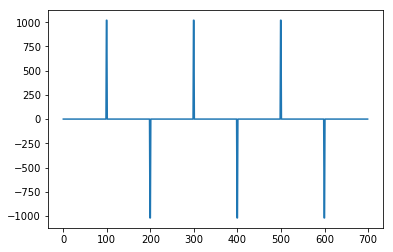

In [43]:
sobelx_kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
print(sobelx_kernel)

# Converte matriz da imagem para float64 (requisito para que cv2.filter2D funcione corretamente com valores negativos)
img = img.astype(np.float64)

img1_sobelx = cv2.filter2D(img,-1,sobelx_kernel)
img2_sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)  # O terceiro e quarto parâmetros indicam a direção: 1,0 para x; 0,1 para y;
plt.figure(1)
plt.plot(img1_sobelx[4])
#plt.plot(img2_sobelx[4])
print("O valor máximo do gradx é: ", np.max(img1_sobelx),"\nO valor mínimo do gradx é: ",np.min(img1_sobelx) )

Observe que os valores do gradiente na direção x são positivos quando a transição ocorre do preto para o branco, e negativo nas transições do branco para preto.

Portanto, é importante considerar o valor absoluto do gradiente ao detectar as bordas. Observe o que acontece quando o resultado da aplicação do filtro Sobel na direção x é mostrado na forma de imagem.

Mostrar como imagem os valores absolutos do resultado do filtro SobelX


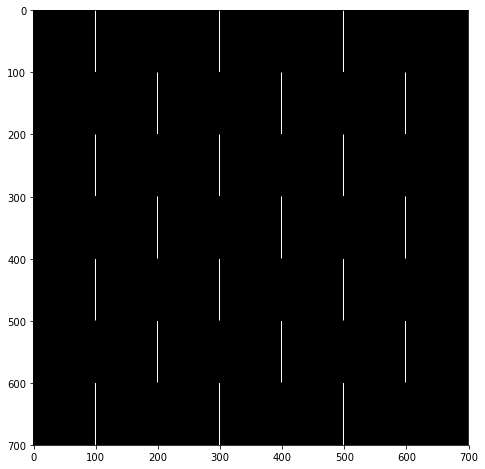

In [44]:
print("Mostrar como imagem os valores absolutos do resultado do filtro SobelX")

diplay_sobelx = np.copy(img1_sobelx)

diplay_sobelx[diplay_sobelx < 0] = 0

plt.figure(figsize=(8,8))
plt.imshow(diplay_sobelx, cmap='gray')
plt.show()

Lembre-se que a função `cv2_imshow` satura os valores entre 0 e 255 ao mostrar a matrix resultante. Por isso apenas as transições que geram gradiente positivo são mostradas.

A seguir o módulo do resultado mostrado na forma de imagem


Mostrar como imagem os valores absolutos do resultado do filtro SobelX


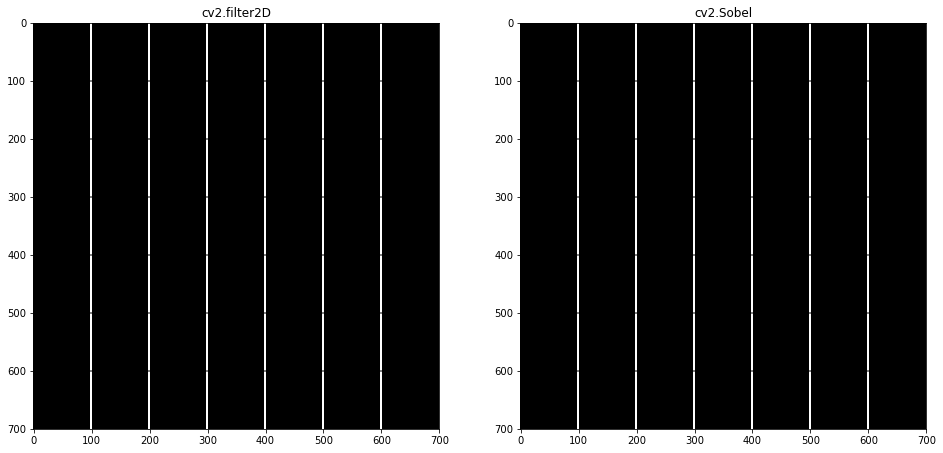

In [45]:
print("Mostrar como imagem os valores absolutos do resultado do filtro SobelX")

plt.figure(figsize=(16,8))

plt.subplot(121)
plt.imshow(np.absolute(img1_sobelx), cmap='gray')
plt.title('cv2.filter2D')

plt.subplot(122)
plt.imshow(np.absolute(img2_sobelx), cmap='gray')
plt.title('cv2.Sobel')

plt.show()

Alternativamente, é possível usar a função `cv2.convertScaleAbs` que usa escala o valor absoluto da matrix para que fique entre 0 e 255. Veja como fica o gráfico da quinta linha da matriz resultante após essa função ser aplicada.

O valor máximo do gradx é:  255 
O valor mínimo do gradx é:  0


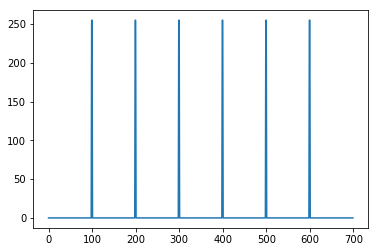

In [46]:
plt.figure(1)
img1_sobelx_abs_scaled = cv2.convertScaleAbs(img1_sobelx)
plt.plot(img1_sobelx_abs_scaled[4])

print("O valor máximo do gradx é: ", np.max(img1_sobelx_abs_scaled),"\nO valor mínimo do gradx é: ",np.min(img1_sobelx_abs_scaled) )

### Exercício A.1

Usando uma das formas de calcular o gradiente da imagem na direção y utilizando o filtro Sobel, mostre o valor absoluto do resultado (semelhante a imagem anterior) na forma de imagem. Aplique na imagem sem ruído.


[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]
Mostrar como imagem os valores absolutos do resultado do filtro SobelY


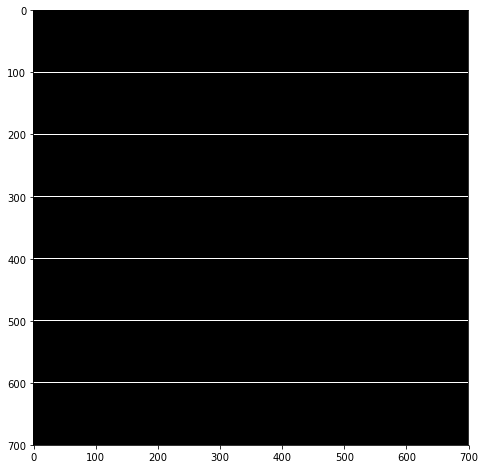

In [47]:
######## Coloque aqui seu código #############
sobely_kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]).T
print(sobely_kernel)

img1_sobely = cv2.filter2D(img,-1,sobely_kernel)
img1_sobely_abs_scaled = cv2.convertScaleAbs(img1_sobely)

#############################################
print("Mostrar como imagem os valores absolutos do resultado do filtro SobelY")

plt.figure(figsize=(8,8))
plt.imshow(img1_sobely_abs_scaled, cmap='gray')
plt.show()

### Exercício A.2

O módulo dos gradientes na direção x e y podem ser somados com peso 0.5 para cada um usando a função `cv2.addWeighted`. 

Combine os gradientes x e y obtidos pelos filtros do tipo Sobel (aplicados na imagem sem ruído) e mostre na forma de imagem.


Mostrar como imagem os valores absolutos do Sobel X e Sobel Y combinados


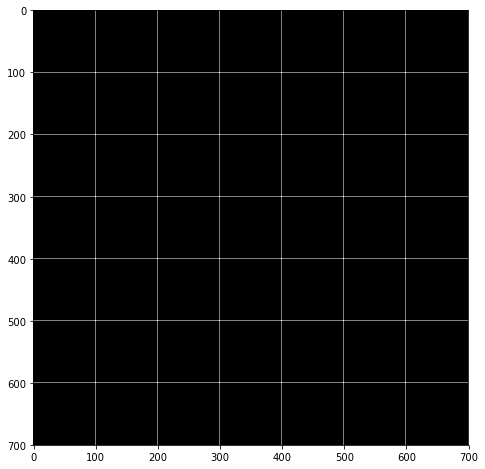

In [48]:
############# Coloque seu código a seguir
img1_sobel_xy = cv2.addWeighted(img1_sobely_abs_scaled, 0.5, img1_sobelx_abs_scaled, 0.5, 0)

###############################
print("Mostrar como imagem os valores absolutos do Sobel X e Sobel Y combinados")

plt.figure(figsize=(8, 8))
plt.imshow(img1_sobel_xy, cmap='gray')
plt.show()

### Exercício A.3

Agora aplique na imagem corrompida com ruído Gaussiano, o filtro Sobel em ambas as direções, combinando o resultado para o obter o gradiente final.

Complete o código a seguir.


Mostrar como imagem os valores absolutos do Sobel X e Sobel Y combinados


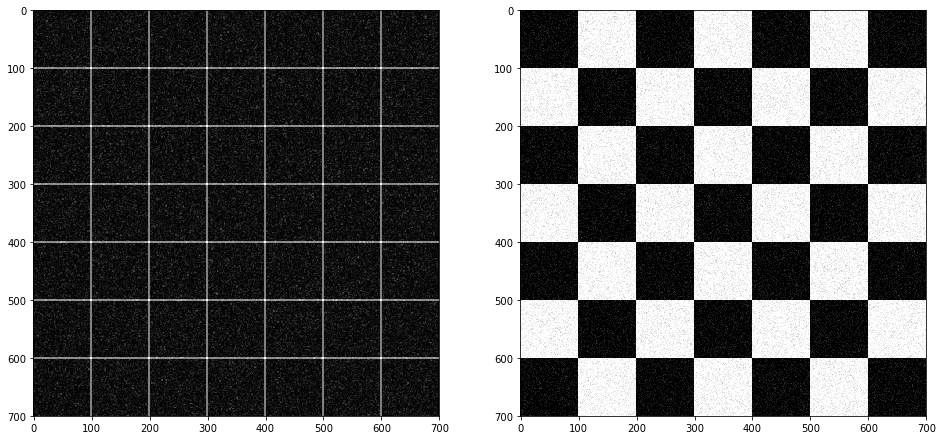

In [49]:

# Converte matriz da imagem para float64 (requisito para que cv2.filter2D funcione corretamente com valores negativos)
img_ruido = img_ruido.astype(np.float64)

############# Coloque seu código a seguir

img_ruido_sobelx = cv2.filter2D(img_ruido,-1,sobelx_kernel)
img_ruido_sobelx_abs_scaled = cv2.convertScaleAbs(img_ruido_sobelx)

img_ruido_sobely = cv2.filter2D(img,-1,sobely_kernel)
img_ruido_sobely_abs_scaled = cv2.convertScaleAbs(img_ruido_sobely)

img1_sobel_xy = cv2.addWeighted(img_ruido_sobelx_abs_scaled, 0.5, img_ruido_sobely_abs_scaled, 0.5, 0)

###############################
print("Mostrar como imagem os valores absolutos do Sobel X e Sobel Y combinados")

plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(img1_sobel_xy, cmap='gray')

plt.subplot(122)
plt.imshow(img_ruido.reshape(img_ruido.shape[:-1]), cmap='gray')

plt.show()

### Detecção de borda usando o Laplaciano

O filtro Laplaciano pode ser usado para detectar ao mesmo tempo as bordas verticais e horizontais:

$$L = \begin{bmatrix} 0 & 1 & 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0 \end{bmatrix}$$

### Exercício A.3

Complete o código a seguir para aplicar o filtro Laplaciado na imagem sem ruído e mostrar o valor absoluto da matrix resultante como sendo uma imagem. Consulte o manual do OpenCV para usar a função `cv2.Laplacian`, ou utilize a função `cv2.filter2D`.

Mostrar como imagem os valores absolutos do resultado do filtro Laplaciano


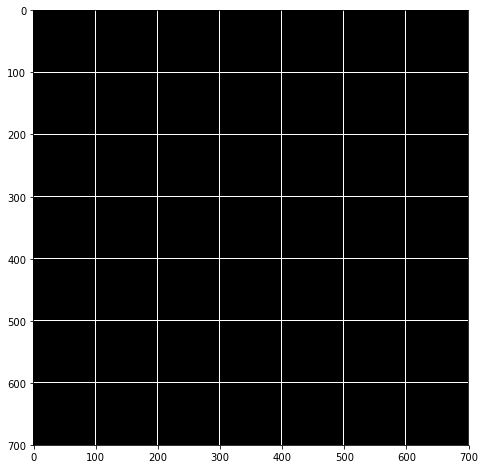

In [50]:
############# Coloque seu código a seguir

laplace = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

img_laplacian_border = cv2.filter2D(img, -1, laplace)

img1_laplacian_abs_scaled = cv2.convertScaleAbs(img_laplacian_border)
###############################

print("Mostrar como imagem os valores absolutos do resultado do filtro Laplaciano")

plt.figure(figsize=(16, 8))
plt.imshow(img1_laplacian_abs_scaled, cmap='gray')
plt.show()

Faça o mesmo para a imagem de teste com ruido branco Gaussiano.


Mostrar como imagem os valores absolutos do resultado do filtro Laplaciano


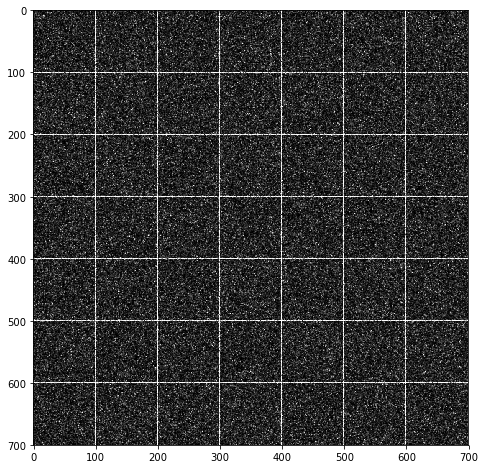

In [51]:
# Converte matriz da imagem para float64 (requisito para que cv2.filter2D funcione corretamente com valores negativos)
img_ruido = img_ruido.astype(np.float64)

############# Coloque seu código a seguir

img_ruido_laplacian_border = cv2.filter2D(img_ruido, -1, laplace)

img_ruido_laplacian_abs_scaled = cv2.convertScaleAbs(img_ruido_laplacian_border)
###############################

print("Mostrar como imagem os valores absolutos do resultado do filtro Laplaciano")

plt.figure(figsize=(16, 8))
plt.imshow(img_ruido_laplacian_abs_scaled, cmap='gray')
plt.show()

### Detector de Borda usando Método de Canny

Consulte a documentação do OpenCV para o [detector de borda de Canny](https://docs.opencv.org/master/da/d22/tutorial_py_canny.html). A definição dos parâmetros da função está na documentação da função [`cv2.Canny`](https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de).

A seguir um exemplo da aplicação do método na imagem corrompida por um ruído Gaussiano. 

Opcional: tente alterar os valores dos dois limiares (thresholds) para ver como isso afeta o método.


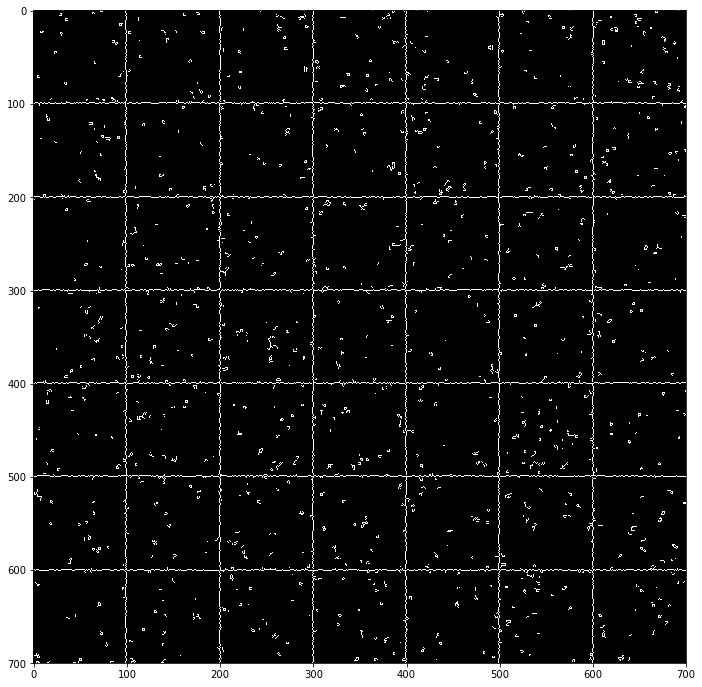

In [52]:
# Converte matriz da imagem para uint8 (requisito da função cv2.Canny)
img_ruido = img_ruido.astype(np.uint8)

edges = cv2.Canny(img_ruido,100,200)

plt.figure(figsize=(12,12))
plt.imshow(edges, cmap='gray')
plt.show()

## Parte B: Transformada de Hough

Consulte a documentação da [transformada de Hough](https://docs.opencv.org/master/d6/d10/tutorial_py_houghlines.html) no tutorial do OpenCV e a documentação da função [`cv2.HoughLines`](https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a) e [`cv2.HoughLinesP`](https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb).

O código a seguir aplica a Transformada de Hough no resultado obtido pelo detector de borda de Canny.

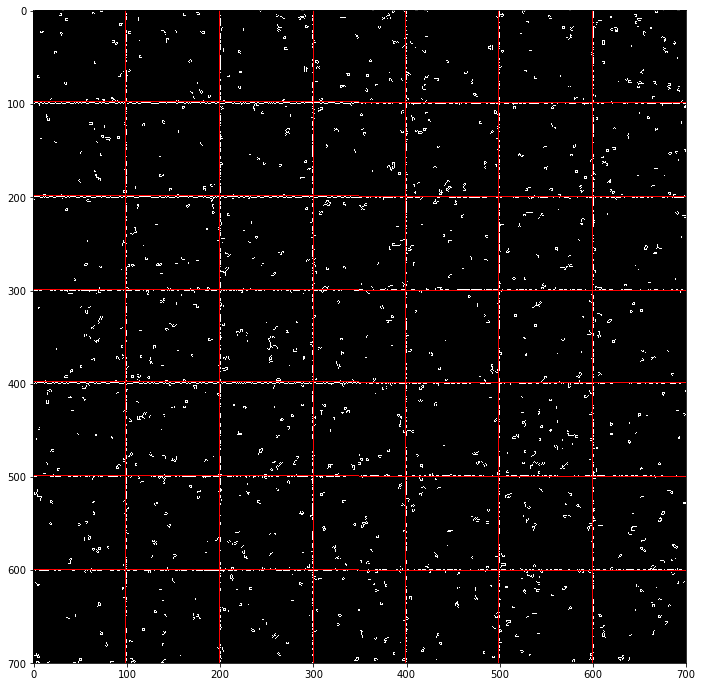

In [53]:
edges_color = cv2.cvtColor(edges,cv2.COLOR_GRAY2RGB)
lines = cv2.HoughLines(edges,1,np.pi/180,200)
for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(edges_color,(x1,y1),(x2,y2),(0,0,255),1)

plt.figure(figsize=(12,12))
plt.imshow(edges_color[:,:,::-1], cmap='gray')
plt.show()

## Parte C: Detector de Cantos

Consulte a documentação do [detector de cantos de Harris](https://docs.opencv.org/master/dc/d0d/tutorial_py_features_harris.html) no tutorial do OpenCV e a documentação da função [`cv2.cornerHarris`](https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345) e [`cv2.cornerSubPix`](https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e).

O código a seguir aplica detector de cantos de Harris na imagem do padrão xadrez corrompida por ruído Gaussiano.

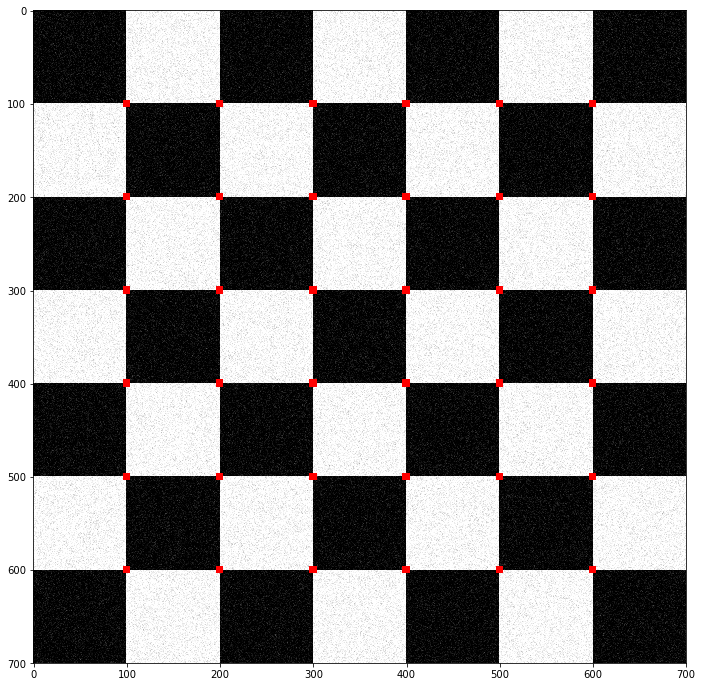

In [54]:
# Converte matriz da imagem para uint8 (requisito da função cv2.Canny)
img_ruido = img_ruido.astype(np.uint8)

img_color = cv2.cvtColor(img_ruido,cv2.COLOR_GRAY2RGB)

dst = cv2.cornerHarris(img_ruido,5,3,0.04)
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img_color[dst>0.01*dst.max()]=[0,0,255]

plt.figure(figsize=(12,12))
plt.imshow(img_color[:,:,::-1], cmap='gray')
plt.show()

### Exercício C.1 

O algoritmo de detecção de cantos apresentado no livro "Introductory Techniques for 3D Computer Vision" que também foi apresentado em aula, é uma versão modificada do algoritmo de detecção de Harris.

Neste exercício, o algoritmo apresentado em aula será implementado utiizando as funções de `cv2.Filter2D`, e funções da biblioteca numpy.

Complete o código a seguir para obter uma matriz de parâmetros $\lambda_1$ e $\lambda_2$. O tamanho da região de vizinhança $Q$ é definido por $(2N+1)\times(2N+1)$.


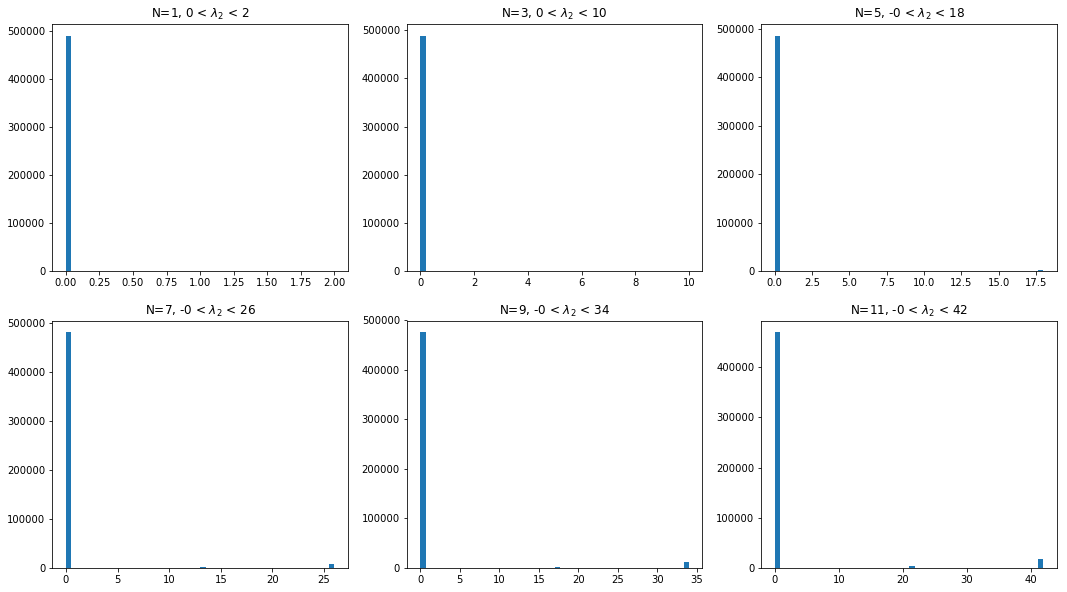

In [65]:
def max_autovalor(img, N, ax):
    img_ruido = adiciona_ruido_gaussiano(img,20) 

    # Converte matriz da imagem para float64 (requisito para que cv2.filter2D funcione corretamente com valores negativos)
    img_ruido = img_ruido.astype(np.float64)

#     print("Tamanho da imagem: ", img_ruido.shape)
    img_size = img_ruido.shape   # Recupera o tamanho da imagem
    X=img_size[0]
    Y=img_size[1]

    # Calcula o gradiente x e y utilizando o filtro Sobel 
    sobelx_kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])  # Kernel para Sobel X
    sobely_kernel = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])  # Kernel para Sobel Y
    ############## Completar linhas a seguir #######################
    img1_gradx = cv2.filter2D(img,-1,sobelx_kernel)
    img1_grady = cv2.filter2D(img,-1,sobely_kernel)
    ############################################################

    # Obtenha o valor de Ex^2, onde Ex é o gradiente na direção x. Use a função np.multiply para fazer multiplicação elemento por elemento entre matrizes
    ############## Completar linha a seguir #######################
    gradxx = np.multiply(img1_gradx, img1_gradx)
    ############################################################
    max_gradxx= np.max(gradxx)
    gradxx = gradxx/max_gradxx

    # Obtenha o valor de Ey^2, onde Ey é o gradiente na direção y. Use a função np.multiply para fazer multiplicação elemento por elemento entre matrizes
    ############## Completar linha a seguir #######################
    gradyy = np.multiply(img1_grady, img1_grady)
    ############################################################
    gradyy = gradyy/max_gradxx

    # Obtenha o valor absoluto de Ex*Ey. Use a função np.multiply para fazer multiplicação elemento por elemento entre matrizes, e np.absolute para obter o valor absoluto de cada elemento
    ############## Completar linha a seguir #######################
    gradxy = np.abs(np.multiply(img1_gradx, img1_grady))
    ############################################################
    gradxy = gradxy/max_gradxx

    # Divida os valores de gradxx, gradxy, gradyy por um valor constante bem alto. Isso evita estourar o valor máximo que a variável float pode representar

    # Utiliza o filtro 2D a seguir do tamanho da vizinha Q composto por 1 para obter a soma de Ex^2, Ey^2, e Ex*Ey dentro da vizinhaça
    # Dessa forma, cada posição p da imagem, serão calculado os componentes da matriz C 
    sum_kernel = np.ones((2*N+1,2*N+1))
    ############## Completar linhas a seguir #######################
    sum_gradxx = cv2.filter2D(gradxx, -1, sum_kernel)
    sum_gradxy = cv2.filter2D(gradxy, -1, sum_kernel)
    sum_gradyy = cv2.filter2D(gradyy, -1, sum_kernel)
    ############################################################

    # Para montar a matriz C, é preciso reorganizar os componentes da matriz C para que fiquem em vetores de uma dimensão
    sum_gradxx=sum_gradxx.flatten()
    sum_gradxy=sum_gradxy.flatten()
    sum_gradyy=sum_gradyy.flatten()

    # Monta a matriz C, que terá dimensão (2,2,X*Y)
    C = np.array([[sum_gradxx,sum_gradxy],[sum_gradxy,sum_gradyy]])

    # Reorganiza a matriz C, para que seja um vetor de dimentão (x*Y) de matrizes (2,2), ou seja, possua dimensão (X*Y,2,2) 
    C = C.transpose(2, 0, 1)
    # A função np.linalg.eigh calcula os autovalores para as todas as matrizes (..,2,2) do vetor de matrizes (veja documentação da função eigh)
    w, v = np.linalg.eigh(C)
    l2 = w[:,0] # Vetor com o menor autovalor (lambda2)
    l1 = w[:,1] # Vetor com o maior autovalor (lambda1)

    # Imprime o maior valor de lambda2 e o menor valor
#     print("O maior valor de lambda2 é ", np.max(l2), " e o menor valor é ", np.min(l2))

    # Plota o histograma dos valores de lambda2
    # fig = plt.figure()
    # a1 = fig.add_axes([0,0,1,1])
    #a1.set_xlim(0,50)
    ax.hist(l2,50)
    ax.set_title(f'{N=}, {np.min(l2):.0f} < $\lambda_2$ < {np.max(l2):.0f}')
    
    return l2
# plt.show()

# Controla o tamanho da vizinhança Q (OPCIONAL: Altere o valor de N e observe o que acontece com o histograma e com o resultado final)
N = np.array([1, 3, 5, 7, 9, 11])
img = padrao_xadrez()

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(18, 10))

for i, (n, ax) in enumerate(zip(N[:-1], axs.flatten())):
    max_autovalor(img, n, ax)

l2_xadrez = max_autovalor(img, N[-1], axs[-1][-1])
    
plt.show()

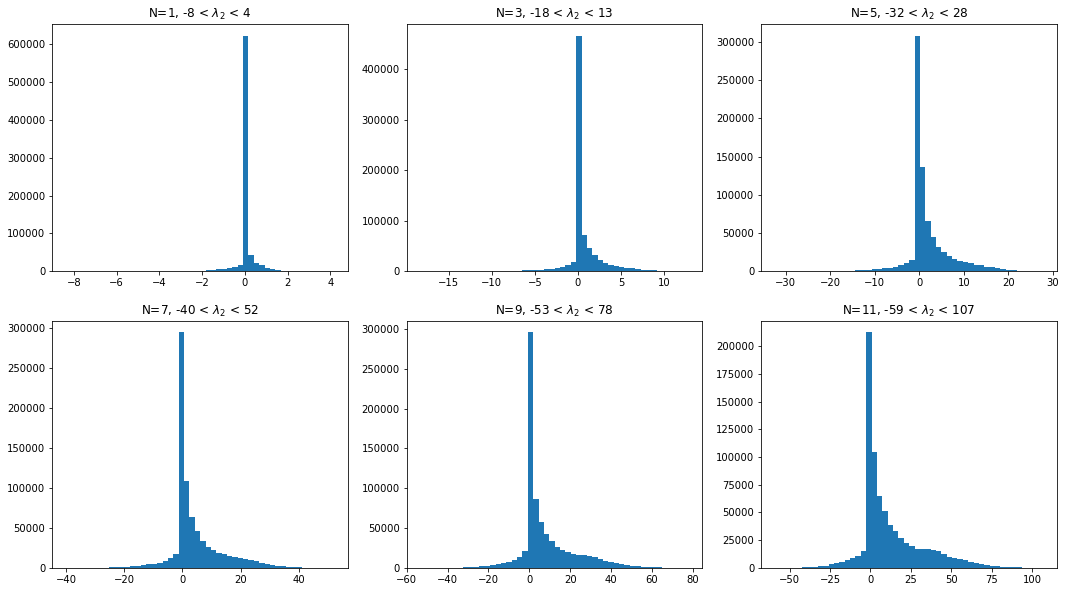

In [69]:
N = [1, 3, 5, 7, 9, 11]

# OPCIONAL: Para testar com a imagem do Buzz descomente a linha a seguir
img_buzz = cv2.imread('../imgs/buzz_gray.png',cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(18, 10))

for n, ax in zip(N[:-1], axs.flatten()):
    max_autovalor(img_buzz, n, ax)
    
l2_buzz = max_autovalor(img_buzz, N[-1], axs[-1][-1])

plt.show()

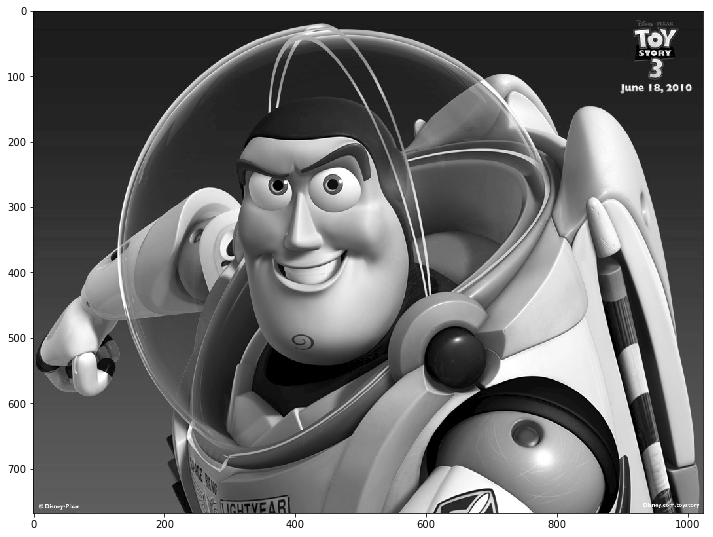

In [57]:
plt.figure(figsize=(12,12))
plt.imshow(img_buzz, cmap='gray')
plt.show()

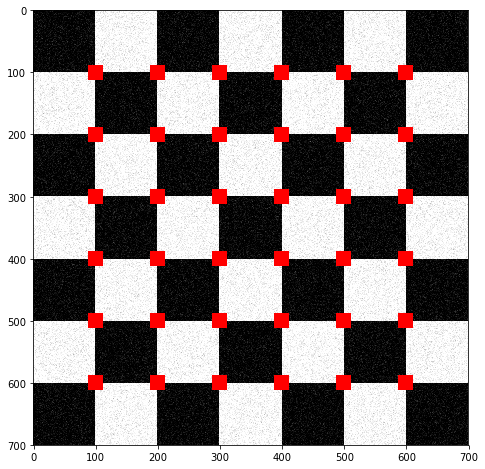

In [67]:
img_ruido = adiciona_ruido_gaussiano(img,20) 

# Define um threshold para o valor de lambda2 (altere esse valor de acordo com o histograma de lambda2)
t2 = 1

# Reorganiza o vetor de lambda2 na forma de uma matriz do tamanho da imagem
l2 = l2_xadrez.reshape(img_ruido.shape[:-1])

# Transforma a imagem corrompida com ruido em imagem colorida
img_color = cv2.cvtColor(img_ruido,cv2.COLOR_GRAY2RGB)

# Mostra em vermelho as posições de p onde o valor de lambda2 é maior que um threshold
img_color[l2 > t2]=[0,0,255]

# Observe que não foi feita a parte de eliminar janelas sobrepostas a partir de uma lista ordenada de lambda2

plt.figure(figsize=(8,8))
plt.imshow(img_color[:,:,::-1])
plt.show()

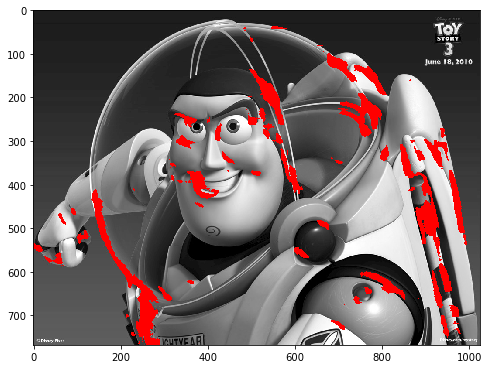

In [73]:
# Define um threshold para o valor de lambda2 (altere esse valor de acordo com o histograma de lambda2)
t2 = 50

# Reorganiza o vetor de lambda2 na forma de uma matriz do tamanho da imagem
l2 = l2_buzz.reshape(img_buzz.shape)

# Transforma a imagem corrompida com ruido em imagem colorida
img_color = cv2.cvtColor(img_buzz,cv2.COLOR_GRAY2RGB)

# Mostra em vermelho as posições de p onde o valor de lambda2 é maior que um threshold
img_color[l2 > t2]=[0,0,255]

# Observe que não foi feita a parte de eliminar janelas sobrepostas a partir de uma lista ordenada de lambda2

plt.figure(figsize=(8,8))
plt.imshow(img_color[:,:,::-1])
plt.show()